In [5]:
%pylab inline
%matplotlib inline
    
import pywt
import numpy as np
import seaborn
from statsmodels.robust import mad
import matplotlib.pyplot as plt  
import sys
import pandas as pd
import datetime
from dateutil.parser import parse
from tqdm import tqdm
import pickle
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

Populating the interactive namespace from numpy and matplotlib


/Users/clz/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [67]:
def waveletSmooth( x, wavelet="db4", level=1, title=None ):
    ''' smooth denoise'''
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    return y

In [57]:

def read(filePath,wetherPath = './data/zhenshitianqi.csv'):
    '''
    read data 2 dict
    '''
    
    filePath='./data/Tianchi_power.csv'
    wetherPath = './data/zhenshitianqi.csv'
    #get wether data
    wetherData = pd.read_csv(wetherPath)[['date','max','min']]
    wetherData['date'] = wetherData['date'].apply(lambda x:parse(str(x)).strftime('%Y-%m-%d'))

    #get power data
    data = pd.read_csv(filePath)
    data['record_date'] = data['record_date'].apply(lambda x:parse(str(x)).strftime('%Y-%m-%d'))
    data['week'] = data['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').weekday())
    data['month'] = data['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').month)
    data['day'] = data['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').day)
    data['year'] = data['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').year)

    #merge
    merged_data = pd.merge(data,wetherData,how='left',left_on='record_date',right_on='date')

    readData = merged_data.set_index('record_date').drop('date',1)
    
    #save
    readData.to_csv("./data/dataRead.csv",index=False)

    print readData.head()
    return readData
    
readData = read('./data/Tianchi_power.csv')

             user_id  power_consumption  week  month  day  year  max  min
record_date                                                              
2015-01-01         1               1135     3      1    1  2015    8   -4
2015-01-02         1                570     4      1    2  2015   13    0
2015-01-03         1               3418     5      1    3  2015   16    3
2015-01-04         1               3968     6      1    4  2015   15    4
2015-01-05         1               3986     0      1    5  2015   10    2


In [65]:
pdf = PdfPages('./data/originyearly.pdf')

def draw(data):
    '''
    read data 2 dict
    '''
    data2 = data.groupby('user_id')
    for key,name in tqdm(data2):
        fig = plt.figure(1,figsize=(20,10))
        timeSerie = pd.Series(data=name['power_consumption'].values,index=name['record_date'])
        ax = plt.plot(timeSerie.values[:365],'b')
        ax = plt.plot(timeSerie.values[365:],'r')
        pdf.savefig()
        plt.close()
    pdf.close()
    return data

data = draw(readData)

100%|██████████| 1454/1454 [02:49<00:00,  9.08it/s]


In [ ]:
# 归一化保存
from sklearn.preprocessing import StandardScaler, RobustScaler

scalerDic={} # store scaler class
def scaleProcess(key,data):
    robust_scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(10.0, 90.0), copy=True)
    data['power_consumption_scale'] = robust_scaler.fit_transform(data['power_consumption'].reshape(-1,1)) 
    scalerDic[key] = robust_scaler
    return data

scaleList=[] # userid scaled matrix
def scaleData(data):
    '''
    read data 2 dict
    '''
    pdf = PdfPages('./data/scale.pdf')
    
    #draw
    data2 = data.groupby('user_id')
    for key,truck in tqdm(data2): 
        scaleData = scaleProcess(key,truck)
        scaleList.append(scaleData)
        
        fig = plt.figure(1,figsize=(20,10))
        timeSerie2 = pd.Series(data=scaleData['power_consumption_scale'].values,index=scaleData.index.values)
        ax = plt.plot(timeSerie2.values,'r')
        pdf.savefig()
        plt.close()
    pdf.close()
 
scaleData(readData)

# scaleList  save 

with open('./data/scaleList', 'wb') as fp:
    pickle.dump(scaleList, fp)
    
with open('./data/scalerDic', 'wb') as fp:
    pickle.dump(scalerDic, fp)   

/Users/clz/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/clz/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:1063: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


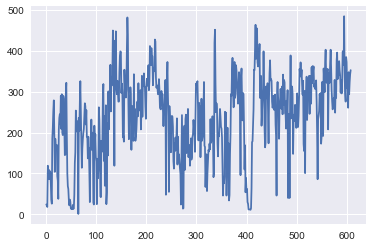

In [77]:
#check
#import matplotlib
#matplotlib.use('Agg')
#import matplotlib.pyplot as plt
#datax = scalerDic[2].inverse_transform(scaleList[1]['power_consumption_scale'])
#plt.plot(datax)

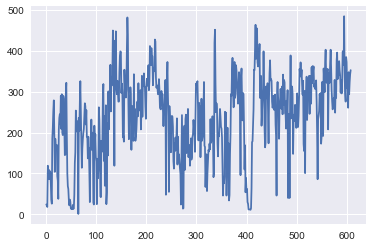

In [76]:
plt.plot(scaleList[1]['power_consumption'].values)

In [6]:
#read scale
with open ('./data/scaleList', 'rb') as fp:
    scaleList = pickle.load(fp)
    
with open ('./data/scalerDic', 'rb') as fp:
    scalerDic = pickle.load(fp)   

In [54]:
# 用去年的预测今年的数据 按照日期对应 1-7月训练 8月validation 
def getTrain(scaleList=scaleList,testMonth=8):
    originTrainXList = []
    originTrainYList = []
    originTestXList=[]
    originTestYList=[]
    
    for userData in tqdm(scaleList):
        #userData = pd.DataFrame(userData)
        trainX = userData[(userData.month < testMonth) & (userData.year == 2015)]
        trainY = userData[(userData.month < testMonth) & (userData.year == 2016)]
        testX = userData[(userData.month == testMonth) & (userData.year == 2015)]
        testY = userData[(userData.month == testMonth) & (userData.year == 2016)]
        
        train_XY = pd.merge(trainX,trainY,how='left',on=['month','day'])
        test_XY = pd.merge(testX,testY,how='left',on=['month','day'])
        
        originTrainXList.append(train_XY[['power_consumption_scale_x','week_x','max_x','min_x']])
        originTrainYList.append(train_XY[['power_consumption_scale_y','week_y','max_y','min_y']])
        originTestXList.append(test_XY[['power_consumption_scale_x','week_x','max_x','min_x']])
        originTestYList.append(test_XY[['power_consumption_scale_y','week_y','max_y','min_y']])
        
    with open('./data/originTrainXList', 'wb') as fp:
        pickle.dump(originTrainXList, fp)
    
    with open('./data/originTrainYList', 'wb') as fp:
        pickle.dump(originTrainYList, fp)
        
    with open('./data/originTestXList', 'wb') as fp: 
        pickle.dump(originTestXList, fp)
        
    with open('./data/originTestYList', 'wb') as fp:
        pickle.dump(originTestYList, fp)
 
        
    return originTrainXList,originTrainYList,originTestXList,originTestYList

originTrainXList,originTrainYList,originTestXList,originTestYList = getTrain()

100%|██████████| 1454/1454 [00:15<00:00, 92.82it/s]


In [40]:
print len(originTrainXList[1000])

212


In [47]:
# load
with open('./data/originTrainXList', 'rb') as fp:
    originTrainXList = pickle.load(fp)

with open('./data/originTrainYList', 'rb') as fp:
    originTrainYList = pickle.load(fp)

with open('./data/originTestXList', 'rb') as fp: 
    originTestXList = pickle.load(fp)

with open('./data/originTestYList', 'rb') as fp:
    originTestYList = pickle.load(fp)

In [55]:
# LSTM  with window regression framing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# convert an array of values into a dataset matrix
def create_dataset(X, Y,look_back=7):
    dataX, dataY = [], []
    for i in tqdm(range(len(X)-look_back-1)):
        #print X.iloc[i:(i+look_back+1)]
        #print Y.iloc[i:(i+look_back+1)]
        # X consumption scale
        power_consumption_scale = X.iloc[i:(i+look_back)]['power_consumption_scale_x']
        featureX = power_consumption_scale.tolist() # consumption
       
        # weekBinary
        tmp = [0,0,0,0,0,0,0]
        weekNum = Y.iloc[i+look_back]['week_y']
        tmp[int(weekNum)] = 1
        featureX += tmp  #value
        
        # forecast day wether 
        wether_max = Y.iloc[(i+look_back)]['max_y']/30
        wether_min = Y.iloc[(i+look_back)]['min_y']/30
        featureX += [wether_max,wether_min]
        
        dataX.append(featureX)
        
        # Y consumption scale
        power_consumption_scale = Y.iloc[(i+look_back)]['power_consumption_scale_y']
        dataY.append([power_consumption_scale]) # consumption
        
        #print dataX
        #print dataY
        
    return numpy.array(dataX), numpy.array(dataY)
# dataX,dataY = create_dataset(originTrainXList[0],originTrainYList[0])

In [93]:
# reshape into X=t and Y=t+1
look_back = 7
trainX, trainY = create_dataset(originTrainXList[0],originTrainYList[0],look_back=look_back)
testX, testY = create_dataset(originTestXList[0],originTestYList[0],look_back=look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

100%|██████████| 23/23 [00:00<00:00, 775.38it/s]


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(7, input_shape=(1, trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=1, verbose=2)

Epoch 1/1000
2s - loss: 0.0514
Epoch 2/1000
1s - loss: 0.0379
Epoch 3/1000
1s - loss: 0.0343
Epoch 4/1000
1s - loss: 0.0315
Epoch 5/1000
1s - loss: 0.0291
Epoch 6/1000
1s - loss: 0.0276
Epoch 7/1000
1s - loss: 0.0267
Epoch 8/1000
1s - loss: 0.0254
Epoch 9/1000
1s - loss: 0.0245
Epoch 10/1000
1s - loss: 0.0239
Epoch 11/1000
1s - loss: 0.0235
Epoch 12/1000
1s - loss: 0.0226
Epoch 13/1000
1s - loss: 0.0224
Epoch 14/1000
1s - loss: 0.0221
Epoch 15/1000
1s - loss: 0.0212
Epoch 16/1000
1s - loss: 0.0212
Epoch 17/1000
1s - loss: 0.0210
Epoch 18/1000
1s - loss: 0.0208
Epoch 19/1000
1s - loss: 0.0209
Epoch 20/1000
1s - loss: 0.0204
Epoch 21/1000
1s - loss: 0.0203
Epoch 22/1000
1s - loss: 0.0203
Epoch 23/1000
1s - loss: 0.0200
Epoch 24/1000
1s - loss: 0.0200
Epoch 25/1000
1s - loss: 0.0194
Epoch 26/1000
1s - loss: 0.0197
Epoch 27/1000
1s - loss: 0.0191
Epoch 28/1000
1s - loss: 0.0195
Epoch 29/1000
1s - loss: 0.0191
Epoch 30/1000
1s - loss: 0.0187
Epoch 31/1000
1s - loss: 0.0187
Epoch 32/1000
1s 

In [87]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [89]:
# invert predictions
trainPredict = scalerDic[1].inverse_transform(trainPredict.reshape(-1,1))
trainY = scalerDic[1].inverse_transform(trainY.reshape(-1,1))
testPredict = scalerDic[1].inverse_transform(testPredict.reshape(-1,1))
testY = scalerDic[1].inverse_transform(testY.reshape(-1,1))

Train Score: 77.44 RMSE
Test Score: 163.07 RMSE


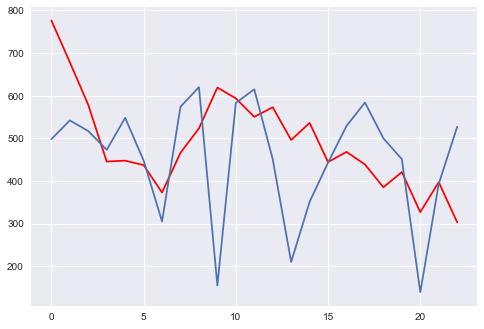

In [91]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainPredict, trainY))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testPredict, testY))
print('Test Score: %.2f RMSE' % (testScore))
plt.plot(testPredict,'r-')
plt.plot(testY)
#plt.show()

In [ ]:
def sumAll(data):
    '''sum by day'''
    dataSum = pd.DataFrame()
     
  
    dataSum['sum_consumption'] = data.groupby('record_date')['smooth'].sum() 

    dataSum['record_date'] = dataSum.index
    dataSum['week'] = dataSum['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').weekday())
    dataSum['month'] = dataSum['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').month)
    dataSum['day'] = dataSum['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').day)
  
    return dataSum
    
#  1.read and processdata   
dataRead = read("./data/Tianchi_power.csv")
dataRead.to_csv("./data/dataRead.csv",index=False)
plt.plot(dataRead[dataRead==1000]['power_consumption'])
print dataRead.head() 